```
This software is part of GPU Ocean. 

Copyright (C) 2017, 2018, 2019 SINTEF Digital
Copyright (C) 2017, 2018, 2019 Norwegian Meteorological Institute

This notebook simulates planetary Rossby waves when north points to
different directions.

This program is free software: you can redistribute it and/or modify
it under the terms of the GNU General Public License as published by
the Free Software Foundation, either version 3 of the License, or
(at your option) any later version.

This program is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
GNU General Public License for more details.

You should have received a copy of the GNU General Public License
along with this program.  If not, see <http://www.gnu.org/licenses/>.
```

# Planetary Rossby Waves with Different North Directions

The notebook is based on `../testCasesDemos/CaseE_RossbyWaves.ipynb`


#### Import modules and set up environment

In [1]:
#Lets have matplotlib "inline"
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

#Import packages we need
import numpy as np
from matplotlib import animation, rc
from matplotlib import pyplot as plt

from netCDF4 import Dataset
import importlib


import os
import datetime
import sys
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '../../')))

#Set large figure sizes
rc('figure', figsize=(16.0, 12.0))
rc('animation', html='html5')

#Import our simulator
from SWESimulators import CDKLM16, PlotHelper, Common, WindStress
#Import initial condition and bathymetry generating functions:
from SWESimulators.BathymetryAndICs import *

In [2]:
gpu_ctx = Common.CUDAContext()

In [3]:
#Create output directory for images
folder='planetaryRossbyWaves_' + datetime.datetime.now().strftime("%Y_%m_%d-%H_%M_%S")
os.makedirs(folder)
print ("Saving to " + folder)

Saving to planetaryRossbyWaves_2019_11_13-11_25_51


## Parameters

In [4]:
nx = 350
ny = 350

dx = 20000.0
dy = 20000.0

dt = 100
g = 9.81
r = 0.0

# Coriolis parameters: f + beta * y
f = 8.0e-5
beta = 2.0e-11
#y_zero_reference_cell = ny/2 

### Need to find f for each case, so since reference cell is always lower left.


wind = WindStress.WindStress()

# Boundary condions
# 1: reflective wall, 
# 2: periodic, 
# 3: open (flow relaxation scheme), 
bcSettings = 3


waterHeight = 50 # m

#Calculate radius from center for plotting
x_center = dx*nx*0.5
y_center = dy*ny*0.5
y_coords, x_coords = np.mgrid[0:ny*dy:dy, 0:nx*dx:dx]
x_coords = np.subtract(x_coords, x_center)
y_coords = np.subtract(y_coords, y_center)
radius = np.sqrt(np.multiply(x_coords, x_coords) + np.multiply(y_coords, y_coords))


# Simulate the following loop:
# for i in range(T):
#     sim.step(sub_T)
#     sim.download and animate (and write to netCDF)

T = 10
sub_T = dt*3000
timesteps = np.arange(sub_T, sub_T*(T+1), sub_T)

bump_posx = 0.5
bump_posy = 0.5
bump_width_factor = 5000 # Pre 2018-01-17: 5000
bump_height = 0.25

print( "Evaluation of the chosen parameters")
latitude = 33.35
omega = 2*np.pi/(3600*24.0)
theoretic_beta = (2*omega/6371e3)*np.cos(np.pi*latitude/180) 
print("theoretic beta: ", theoretic_beta)
print("beta we use: ", beta)
theoretic_f = 2*omega*np.sin(np.pi*latitude/180)
print("theoretic f0: ", theoretic_f)
print( "f0 we use: ", f)

alpha = beta/f
print( "This gives us an alpha: ", alpha)
print( "height of domain with low and high diff: ", ny*dy, waterHeight*ny*dy*alpha)

rossby_radius = np.sqrt(g*waterHeight)/f 
print( "With a depth of " + str(waterHeight) + " we get a Rossby radius (grid cells): ", rossby_radius, (rossby_radius/dx))
size_of_bump_L = 25*dx
print( "Size of bump (grid cells): ", size_of_bump_L, (size_of_bump_L/dx))

print( "L should be much smaller than a --> L*a = ", size_of_bump_L*alpha)

print( "(This last thing means that the change of depth across the bump should be small (for topographic rossby waves))")


Evaluation of the chosen parameters
theoretic beta:  1.9069772823589013e-11
beta we use:  2e-11
theoretic f0:  7.995818555391529e-05
f0 we use:  8e-05
This gives us an alpha:  2.5e-07
height of domain with low and high diff:  7000000.0 87.5
With a depth of 50 we get a Rossby radius (grid cells):  276840.43237937626 13.842021618968813
Size of bump (grid cells):  500000.0 25.0
L should be much smaller than a --> L*a =  0.125
(This last thing means that the change of depth across the bump should be small (for topographic rossby waves))


### Initial condition makers

In [5]:
"""
Defines a gaussian bump in the surface, which is balanced according to the 
geostrophic balance by hu and hv.
"""
def initializeBalancedBumpOverPointAngle(eta, hu, hv, # allocated buffers to be filled with data (output)
                                         nx, ny, dx, dy, ghosts, # grid data
                                         rel_x0, rel_y0, # relative placement of bump center
                                         bump_height, rel_bump_width, # bump information
                                         f0, beta, angle, # parameters defined at the bump centre (coriolis force, water depth)
                                         g,  H0, # Other parameters (gravity)
                                         ):
    staggered = not (eta.shape == hu.shape)
    staggered_increment = int(staggered)*1
    staggered_x = int(staggered)*0.5*dx
    staggered_y = int(staggered)*0.5*dy
    #print "Staggered_{x,y,increment}: ", staggered_x, staggered_y, staggered_increment
    # Find center of bump
    x0 = nx*dx*rel_x0
    y0 = ny*dy*rel_y0
    bump_width = rel_bump_width*500*min(dx, dy)
    
    for j in range(-ghosts[2], ny+ghosts[0]):
        #y = (j+0.5)*dy
        y = (j)*dy
        rel_y = y - y0
        y_hv = y - staggered_y
        rel_y_hv = y_hv - y0
        for i in range(-ghosts[3], nx+ghosts[1]):
            #x = (i+0.5)*dx
            x = (i)*dx
            rel_x = x - x0
            x_hu = x - staggered_x
            rel_x_hu = x_hu - x0
            
            eta[j+ghosts[2], i+ghosts[1]] = eta_gauss_func(rel_x, rel_y, bump_height, bump_width)
            
            hu[j+ghosts[2], i+ghosts[1]] =  (g*H0/f)*2*(rel_y/bump_width)*eta_gauss_func(rel_x_hu, rel_y, bump_height, bump_width)
            
            hv[j+ghosts[2], i+ghosts[1]] = -(g*H0/f)*2*(rel_x/bump_width)*eta_gauss_func(rel_x, rel_y_hv, bump_height, bump_width)
                

### Run and write sim to file

In [6]:
def ncSimulation(sim, filename, timesteps, interior_domain_only=True, num_substeps=3):
    if (os.path.isfile(filename)):
        print("File " + filename + " already exists, skipping simulation.")
        return
    
    try:
        ncfile = Dataset(filename, 'w')

        var = {}
        var['eta'], var['hu'], var['hv'] = sim.download(interior_domain_only=interior_domain_only)
        _, var['Hm'] = sim.downloadBathymetry(interior_domain_only=interior_domain_only)

        ny, nx = var['eta'].shape

        # Create dimensions
        ncfile.createDimension('time', None) # unlimited
        ncfile.createDimension('x', nx)
        ncfile.createDimension('y', ny)

        ncvar = {}

        # Create variables for dimensions
        ncvar['time'] = ncfile.createVariable('time', 'f8', ('time',))
        ncvar['x'] = ncfile.createVariable('x', 'f4', ('x',))
        ncvar['y'] = ncfile.createVariable('y', 'f4', ('y',))

        # Fill dimension variables
        ncvar['x'][:] = np.linspace(0, nx*sim.dx, nx)
        ncvar['y'][:] = np.linspace(0, ny*sim.dy, ny)

        # Create static variables
        ncvar['Hm'] = ncfile.createVariable('Hm', 'f8', ('y', 'x',), zlib=True)
        ncvar['Hm'][:,:] = var['Hm'][:,:]

        # Create time varying data variables
        for varname in ['eta', 'hu', 'hv']:
            ncvar[varname] = ncfile.createVariable(varname, 'f8', ('time', 'y', 'x',), zlib=True)
        ncvar['num_iterations'] = ncfile.createVariable('num_iterations', 'i4', ('time',))

        #Simulate n timesteps
        timestep_sizes = timesteps[1:] - timesteps[:-1]
        timestep_sizes = np.insert(timestep_sizes, 0, 0)

        progress = Common.ProgressPrinter(5)
        pp = display(progress.getPrintString(0), display_id=True)
        for i, timestep_size in enumerate(timestep_sizes):
            #Don't simulate if first step (store initial conditions also)
            if (timestep_size > 0):
                substep_size = timestep_size / num_substeps
                for j in range(num_substeps):
                    sim.updateDt()
                    print('sim.step('+str(substep_size)+')')
                    sim.step(substep_size)

            var['eta'], var['hu'], var['hv'] = sim.download(interior_domain_only=interior_domain_only)
            ncvar['time'][i] = sim.t
            ncvar['num_iterations'][i] = sim.num_iterations

            abort=False
            for varname in ['eta', 'hu', 'hv']:
                ncvar[varname][i,:,:] = var[varname][:,:] #np.ma.masked_invalid(var[varname][:,:])
                if (np.any(np.isnan(var[varname]))):
                    print("Variable " + varname + " contains NaN values!")
                    abort=True

            if (abort):
                print("Aborting at t=" + str(sim.t))
                ncfile.sync()
                break

            pp.update(progress.getPrintString(i/(len(timestep_sizes)-1)))

    except Exception as e:
        print("Something went wrong:" + str(e))
        raise e
    finally:
        ncfile.close()

## CDKLM 16

In [7]:
importlib.reload(Common)

validDomain = [10, 10, 10, 10]
boundaryConditions = Common.BoundaryConditions(3,3,3,3, spongeCells=validDomain)
ghosts = [10, 10, 10, 10]
        
dataShape = (ny + ghosts[0]+ghosts[2], 
             nx + ghosts[1]+ghosts[3])

eta0 = np.zeros(dataShape, dtype=np.float32, order='C')
u0   = np.zeros(dataShape, dtype=np.float32, order='C');
v0   = np.zeros(dataShape, dtype=np.float32, order='C');

# Bathymetry:
Hi = np.ones((dataShape[0]+1, dataShape[1]+1), dtype=np.float32, order='C')*waterHeight

initializeBalancedBumpOverPoint(eta0, u0, v0, # allocated buffers to be filled with data (output)
                                nx, ny, dx, dy, ghosts, # grid data
                                bump_posx, bump_posy, # relative placement of bump center
                                bump_height, bump_width_factor, # bump information
                                f, waterHeight, # parameters defined at the bump centre (coriolis force, water depth)
                                g)


        


# North up

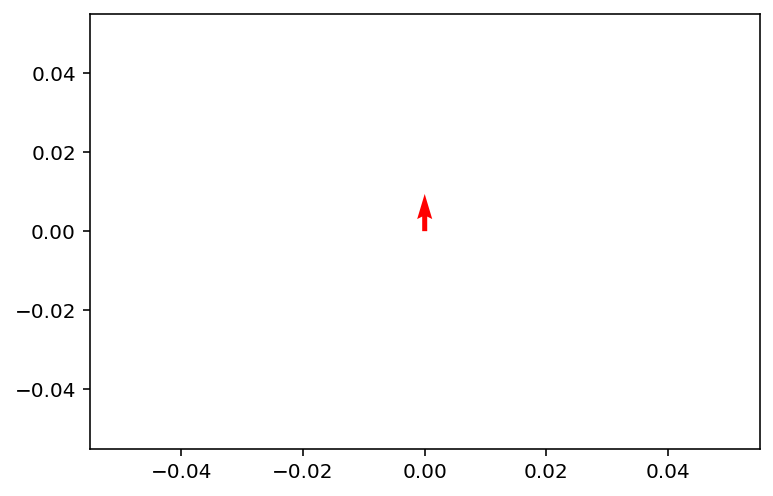

In [8]:
angle_to_north = 0
up_angle = np.array([[angle_to_north]], dtype=np.float32)

north = np.array([np.sin(angle_to_north), np.cos(angle_to_north)])
east = np.array([np.cos(angle_to_north), -np.sin(angle_to_north)])

plt.figure()
plt.quiver(north[0], north[1], color='r')


In [9]:
f0 = f - beta*ny*dy/2
print(f, f0)

#Initialize simulator
up_sim = CDKLM16.CDKLM16(gpu_ctx, \
                         eta0, u0, v0, Hi, \
                         nx, ny, dx, dy, dt, \
                         g, f0, r, \
                         rk_order=2, \
                         coriolis_beta=beta, \
                         #theta=2.0, \
                         wind_stress=wind, \
                         boundary_conditions=boundaryConditions, \
                         angle=up_angle, \
                         )

#eta, hu, hv = up_sim.download(interior_domain_only=True)
#print(eta.shape, hu.shape, hv.shape)
#print(up_sim.boundary_conditions.spongeCells)
#print(up_sim.ny, up_sim.nx)
#print(up_sim.bc_kernel.bc_data.east.shape)
#print(up_sim.bc_kernel.bc_data.north)
#print(up_sim.bc_kernel.bc_data.north.h)
#print(up_sim.bc_kernel.bc_data.north.h.shape)
#squeezed = np.squeeze(up_sim.bc_kernel.bc_data.north.h)
#print(squeezed, type(squeezed), squeezed.shape)
#print(squeezed)



filename = os.path.join(folder, 'north_up_rossby_waves.nc')

runSim = True
#runSim = False

if runSim:
    ncSimulation(sim=up_sim, 
                 filename=filename,
                 timesteps=timesteps,
                 interior_domain_only=True,
                 num_substeps=1)

8e-05 1.0000000000000013e-05


'0% [##############################] 100%. Total: 10s, elapsed: 10s, remaining: 0s'

sim.step(300000.0)
sim.step(300000.0)
sim.step(300000.0)
sim.step(300000.0)
sim.step(300000.0)
sim.step(300000.0)
sim.step(300000.0)
sim.step(300000.0)
sim.step(300000.0)


In [10]:
timesteps

array([ 300000,  600000,  900000, 1200000, 1500000, 1800000, 2100000,
       2400000, 2700000, 3000000])

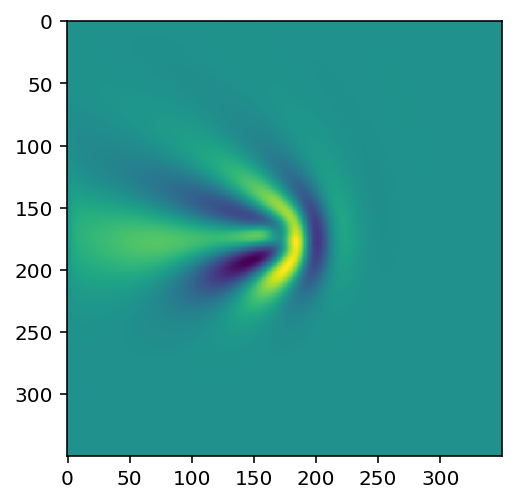

In [11]:
eta_fin, hu_fin, hv_fin = up_sim.download(interior_domain_only=True)

plt.imshow(eta_fin)

# North towards right

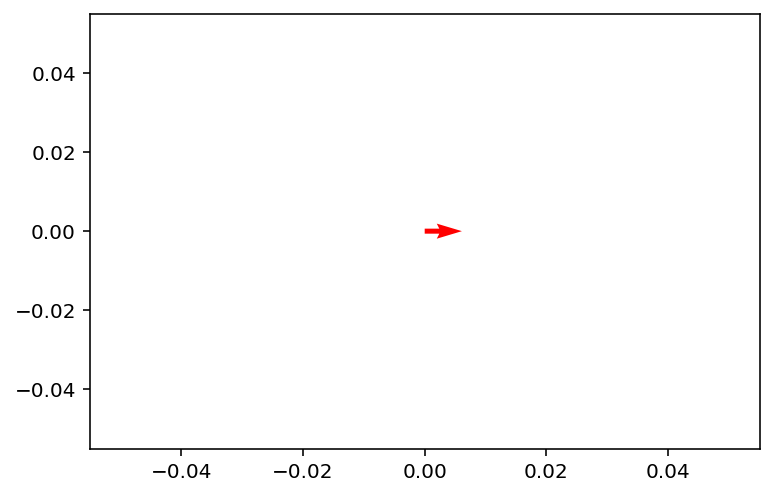

In [12]:
angle_to_north = np.pi/2
right_angle = np.array([[angle_to_north]], dtype=np.float32)

north = np.array([np.sin(angle_to_north), np.cos(angle_to_north)])
east = np.array([np.cos(angle_to_north), -np.sin(angle_to_north)])

plt.figure()
plt.quiver(north[0], north[1], color='r')


In [13]:
f0 = f - beta*nx*dx/2
print(f, f0)

#Initialize simulator
right_sim = CDKLM16.CDKLM16(gpu_ctx, \
                            eta0, u0, v0, Hi, \
                            nx, ny, dx, dy, dt, \
                            g, f0, r, \
                            rk_order=2, \
                            coriolis_beta=beta, \
                            #theta=2.0, \
                            wind_stress=wind, \
                            boundary_conditions=boundaryConditions, \
                            reportGeostrophicEquilibrium=False, \
                            angle=right_angle
                            )

#eta, hu, hv = up_sim.download(interior_domain_only=True)
#print(eta.shape, hu.shape, hv.shape)
#print(up_sim.boundary_conditions.spongeCells)
#print(up_sim.ny, up_sim.nx)
#print(up_sim.bc_kernel.bc_data.east.shape)
#print(up_sim.bc_kernel.bc_data.north)
#print(up_sim.bc_kernel.bc_data.north.h)
#print(up_sim.bc_kernel.bc_data.north.h.shape)
#squeezed = np.squeeze(up_sim.bc_kernel.bc_data.north.h)
#print(squeezed, type(squeezed), squeezed.shape)
#print(squeezed)



right_filename = os.path.join(folder, 'north_right_rossby_waves.nc')

runSim = True
#runSim = False

if runSim:
    ncSimulation(sim=right_sim, 
                 filename=right_filename,
                 timesteps=timesteps,
                 interior_domain_only=True,
                 num_substeps=1)


8e-05 1.0000000000000013e-05


'0% [##############################] 100%. Total: 10s, elapsed: 10s, remaining: 0s'

sim.step(300000.0)
sim.step(300000.0)
sim.step(300000.0)
sim.step(300000.0)
sim.step(300000.0)
sim.step(300000.0)
sim.step(300000.0)
sim.step(300000.0)
sim.step(300000.0)


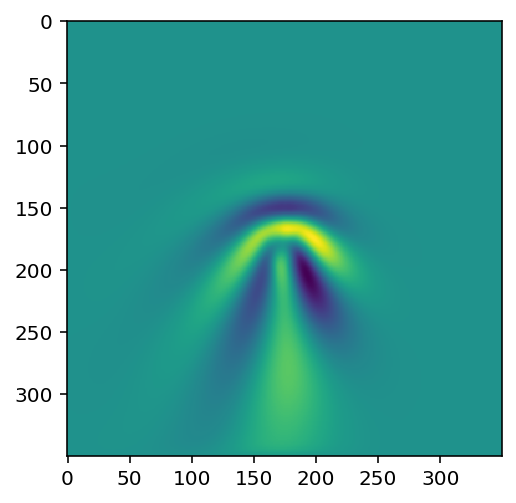

In [14]:
eta_fin, hu_fin, hv_fin = right_sim.download(interior_domain_only=True)

plt.imshow(eta_fin)

# North towards upper right

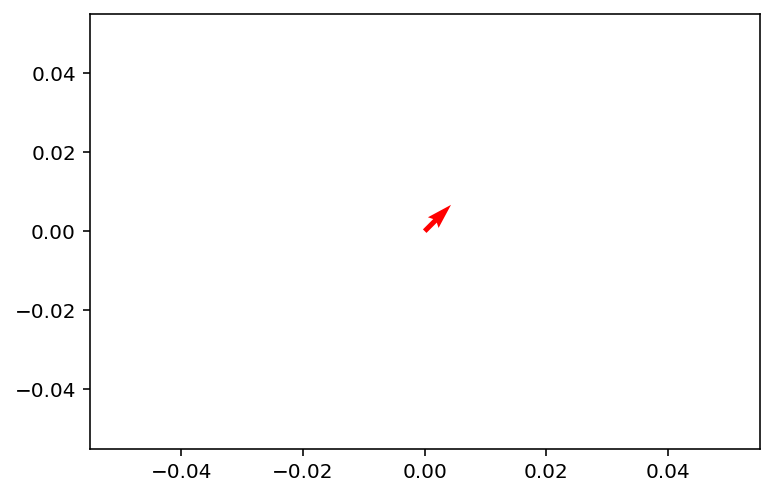

In [15]:
angle_to_north = 1*np.pi/4
upperright_angle = np.array([[angle_to_north]], dtype=np.float32)

north = np.array([np.sin(angle_to_north), np.cos(angle_to_north)])
east = np.array([np.cos(angle_to_north), -np.sin(angle_to_north)])

plt.figure()
plt.quiver(north[0], north[1], color='r')


In [16]:
f0 = f - beta*np.sqrt((ny*dy/2)**2 + (nx*dx/2)**2)
print(f, f0)


#Initialize simulator
upperright_sim = CDKLM16.CDKLM16(gpu_ctx, \
                                 eta0, u0, v0, Hi, \
                                 nx, ny, dx, dy, dt, \
                                 g, f0, r, \
                                 rk_order=2, \
                                 coriolis_beta=beta, \
                                 #theta=2.0, \
                                 wind_stress=wind, \
                                 boundary_conditions=boundaryConditions, \
                                 reportGeostrophicEquilibrium=False, \
                                 angle=upperright_angle
                                 )

#eta, hu, hv = up_sim.download(interior_domain_only=True)
#print(eta.shape, hu.shape, hv.shape)
#print(up_sim.boundary_conditions.spongeCells)
#print(up_sim.ny, up_sim.nx)
#print(up_sim.bc_kernel.bc_data.east.shape)
#print(up_sim.bc_kernel.bc_data.north)
#print(up_sim.bc_kernel.bc_data.north.h)
#print(up_sim.bc_kernel.bc_data.north.h.shape)
#squeezed = np.squeeze(up_sim.bc_kernel.bc_data.north.h)
#print(squeezed, type(squeezed), squeezed.shape)
#print(squeezed)



upperright_filename = os.path.join(folder, 'north_upperright_rossby_waves.nc')

runSim = True
#runSim = False

if runSim:
    ncSimulation(sim=upperright_sim, 
                 filename=upperright_filename,
                 timesteps=timesteps,
                 interior_domain_only=True,
                 num_substeps=1)


8e-05 -1.8994949366116646e-05


'0% [##############################] 100%. Total: 10s, elapsed: 10s, remaining: 0s'

sim.step(300000.0)
sim.step(300000.0)
sim.step(300000.0)
sim.step(300000.0)
sim.step(300000.0)
sim.step(300000.0)
sim.step(300000.0)
sim.step(300000.0)
sim.step(300000.0)


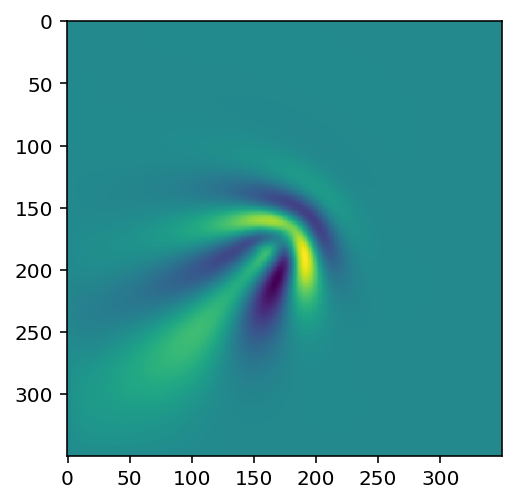

In [17]:
eta_fin, hu_fin, hv_fin = upperright_sim.download(interior_domain_only=True)

plt.imshow(eta_fin)

# North towards lower left

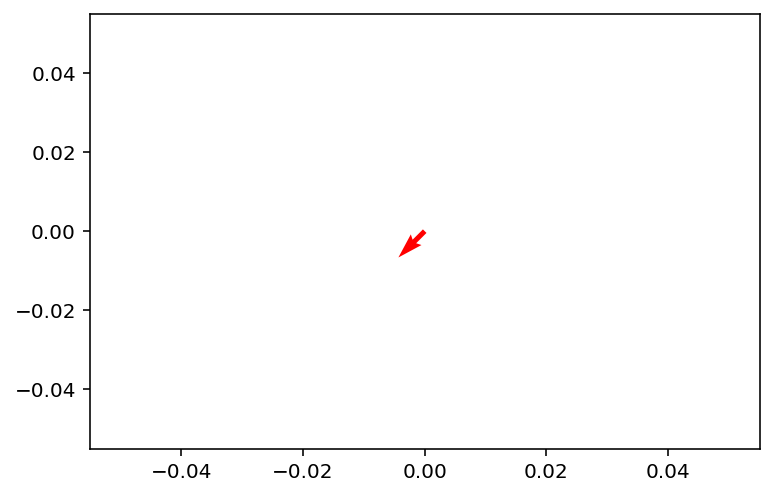

In [18]:
angle_to_north = 5*np.pi/4
lowleft_angle = np.array([[angle_to_north]], dtype=np.float32)

north = np.array([np.sin(angle_to_north), np.cos(angle_to_north)])
east = np.array([np.cos(angle_to_north), -np.sin(angle_to_north)])

plt.figure()
plt.quiver(north[0], north[1], color='r')


In [19]:
f0 = f + beta*np.sqrt((ny*dy/2)**2 + (nx*dx/2)**2)
print(f, f0)

#Initialize simulator
lowleft_sim = CDKLM16.CDKLM16(gpu_ctx, \
                              eta0, u0, v0, Hi, \
                              nx, ny, dx, dy, dt, \
                              g, f0, r, \
                              rk_order=2, \
                              coriolis_beta=beta, \
                              #theta=2.0, \
                              wind_stress=wind, \
                              boundary_conditions=boundaryConditions, \
                              reportGeostrophicEquilibrium=False, \
                              angle=lowleft_angle
                              )

#eta, hu, hv = up_sim.download(interior_domain_only=True)
#print(eta.shape, hu.shape, hv.shape)
#print(up_sim.boundary_conditions.spongeCells)
#print(up_sim.ny, up_sim.nx)
#print(up_sim.bc_kernel.bc_data.east.shape)
#print(up_sim.bc_kernel.bc_data.north)
#print(up_sim.bc_kernel.bc_data.north.h)
#print(up_sim.bc_kernel.bc_data.north.h.shape)
#squeezed = np.squeeze(up_sim.bc_kernel.bc_data.north.h)
#print(squeezed, type(squeezed), squeezed.shape)
#print(squeezed)



lowleft_filename = os.path.join(folder, 'north_lowleft_rossby_waves.nc')

runSim = True
#runSim = False

if runSim:
    ncSimulation(sim=lowleft_sim, 
                 filename=lowleft_filename,
                 timesteps=timesteps,
                 interior_domain_only=True,
                 num_substeps=1)


8e-05 0.00017899494936611667


'0% [##############################] 100%. Total: 10s, elapsed: 10s, remaining: 0s'

sim.step(300000.0)
sim.step(300000.0)
sim.step(300000.0)
sim.step(300000.0)
sim.step(300000.0)
sim.step(300000.0)
sim.step(300000.0)
sim.step(300000.0)
sim.step(300000.0)


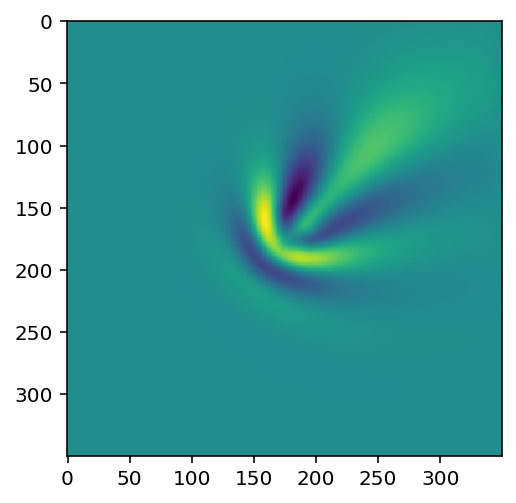

In [20]:
eta_fin, hu_fin, hv_fin = lowleft_sim.download(interior_domain_only=True)

plt.imshow(eta_fin)

# create plots

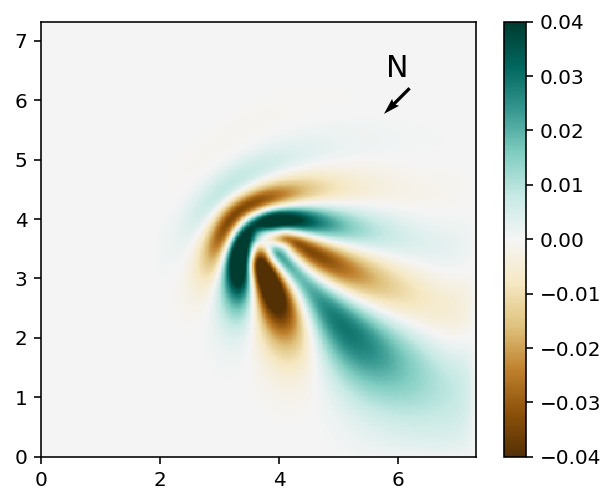

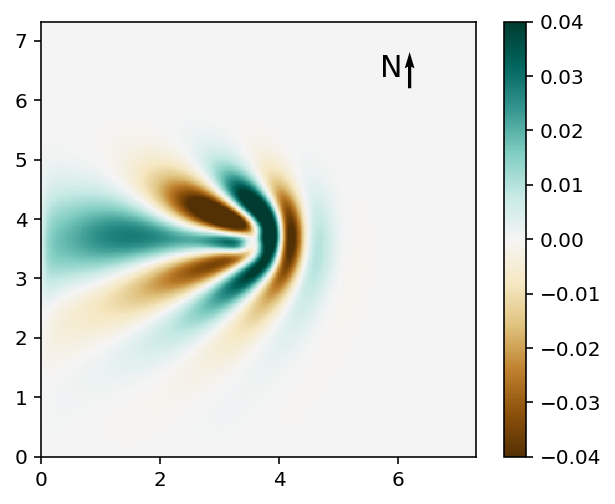

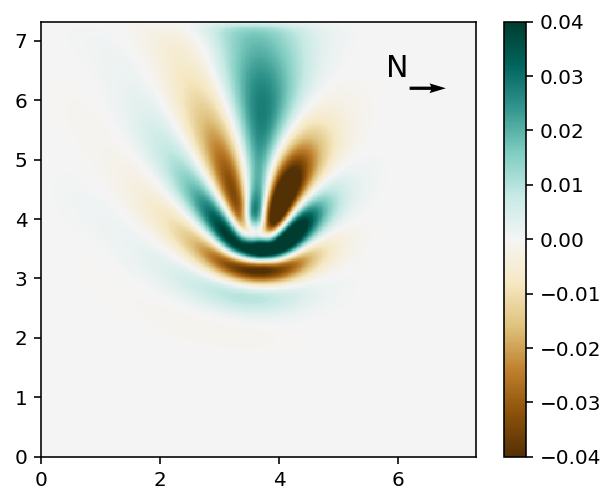

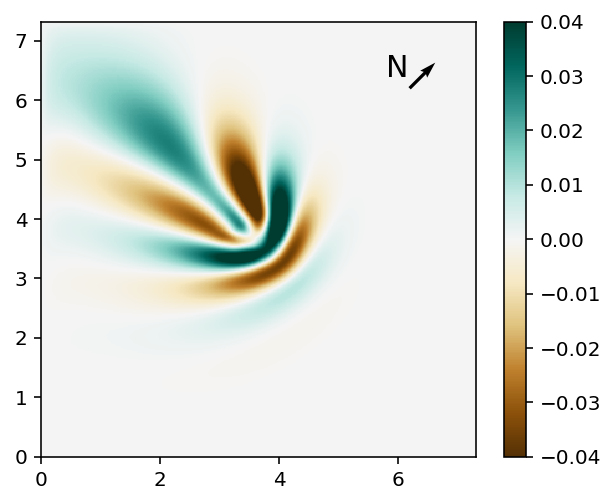

In [21]:
def createPlot(sim, angle_to_north, filename=None):
    
    eta, hu, hv = sim.download(interior_domain_only=True)
    
    
    fig, ax = plt.subplots(figsize=(5,4))
    
    cmap = plt.cm.BrBG
    extent = np.array([0, sim.nx*sim.dx, 0, sim.ny*sim.dy])/1000/1000
    
    eta_max =  0.04
    eta_min = -0.04
    
    im= ax.imshow(eta, interpolation='None', origin='lower', 
                  vmin=-eta_max, vmax=eta_max, extent=extent, cmap=cmap)
    
    fig.colorbar(im)
    
    north = np.array([np.sin(angle_to_north), np.cos(angle_to_north)])
    east = np.array([np.cos(angle_to_north), -np.sin(angle_to_north)])

    ax.quiver(6.200, 6.200, north[0], north[1], color='k', scale=12)
    
    if angle_to_north != 0:
        ax.annotate('N', xy=[5.800, 6.400], fontsize=15)
    else:
        ax.annotate('N', xy=[5.700, 6.400], fontsize=15)
    
    if filename is not None:
        fig.savefig(os.path.join(folder, filename + ".png"), bbox_inches='tight')
        fig.savefig(os.path.join(folder, filename + ".pdf"), bbox_inches='tight')

    
    
createPlot(lowleft_sim, lowleft_angle, 'lowleft')
if True:
    createPlot(up_sim, up_angle, 'up')
    createPlot(right_sim, right_angle, 'right')
    createPlot(upperright_sim, upperright_angle, 'upright')